# Optimized PyTorch CNN with Optuna

In this notebook, we optimize a convolutional neural network (CNN) for the CIFAR-10 dataset using Optuna for hyperparameter tuning.

## Notebook set-up

### Imports

In [ ]:
# Standard library imports
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import optuna
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import (
    roc_curve, auc, 
    precision_recall_curve, average_precision_score
)

from sklearn.preprocessing import label_binarize
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Package imports
from cifar10_tools.pytorch.evaluation import evaluate_model
from cifar10_tools.pytorch.plotting import (
    plot_sample_images, plot_learning_curves, 
    plot_confusion_matrix, plot_class_probability_distributions
)
from cifar10_tools.pytorch.training import train_model

# Suppress Optuna info messages (show only warnings and errors)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Set random seeds for reproducibility
torch.manual_seed(315)
np.random.seed(315)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### Fixed hyperparameters

In [2]:
batch_size = 2048        # Training images come in 5 batches of 10,000

# Optuna settings
start_new_study = True   # Clear previous results (if any) and start new study
n_trials = 20            # Number of optimization trials
n_epochs_per_trial = 20  # Epochs per trial (reduced for faster optimization)
n_epochs_final = 100     # Epochs for final model training

# SQLite storage for Optuna (local file)
logs_dir = Path('../logs')
logs_dir.mkdir(parents=True, exist_ok=True)
storage_path = logs_dir / 'optuna_study.db'
storage_url = f'sqlite:///{storage_path}'

# CIFAR-10 class names in class order
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

num_classes = len(class_names)

## 1. Load and preprocess CIFAR-10 data

CIFAR-10 contains 32x32 color images (3 channels) across 10 classes. We convert the images to grayscale for this demonstration.

### 1.1. Load datasets

In [ ]:
# Make sure data directory exists
data_dir = Path('../data/pytorch/cifar10')
data_dir.mkdir(parents=True, exist_ok=True)

# Data preprocessing: convert to grayscale, tensor, and normalize
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load training and test datasets
train_dataset = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=True,
    transform=transform
)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Image shape: {train_dataset[0][0].shape}')
print(f'Number of classes: {len(class_names)}')

Training samples: 50000
Test samples: 10000
Image shape: torch.Size([1, 32, 32])
Number of classes: 10


### 1.2. Visualize sample images

In [ ]:
# Plot first 10 images from the training dataset
fig, axes = plot_sample_images(train_dataset, class_names, nrows=2, ncols=5)
plt.show()

### 1.2. Create training, validation and testing tensors

In [4]:
# Reshape and preload entire dataset to device for faster training
X_train_full = torch.stack([img for img, _ in train_dataset]).to(device)
y_train_full = torch.tensor([label for _, label in train_dataset]).to(device)

X_test = torch.stack([img for img, _ in test_dataset]).to(device)
y_test = torch.tensor([label for _, label in test_dataset]).to(device)

# Split training data into train and validation sets (80/20 split)
n_train = int(0.8 * len(X_train_full))
indices = torch.randperm(len(X_train_full))

X_train = X_train_full[indices[:n_train]]
y_train = y_train_full[indices[:n_train]]
X_val = X_train_full[indices[n_train:]]
y_val = y_train_full[indices[n_train:]]

print(f'X_train shape: {X_train.shape}, device: {X_train.device}')
print(f'y_train shape: {y_train.shape}, device: {y_train.device}')
print(f'X_val shape: {X_val.shape}, device: {X_val.device}')
print(f'y_val shape: {y_val.shape}, device: {y_val.device}')
print(f'X_test shape: {X_test.shape}, device: {X_test.device}')
print(f'y_test shape: {y_test.shape}, device: {y_test.device}')

X_train shape: torch.Size([40000, 1, 32, 32]), device: cuda:0
y_train shape: torch.Size([40000]), device: cuda:0
X_val shape: torch.Size([10000, 1, 32, 32]), device: cuda:0
y_val shape: torch.Size([10000]), device: cuda:0
X_test shape: torch.Size([10000, 1, 32, 32]), device: cuda:0
y_test shape: torch.Size([10000]), device: cuda:0


### 1.3. Create `DataLoader()` objects

In [5]:
# Create TensorDatasets
train_tensor_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_tensor_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_tensor_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(
    train_tensor_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_tensor_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_tensor_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(f'Training batches: {len(train_loader)}')
print(f'Validation batches: {len(val_loader)}')
print(f'Test batches: {len(test_loader)}')

Training batches: 20
Validation batches: 5
Test batches: 5


## 2. Define CNN architecture with configurable hyperparameters

We create a flexible CNN builder that accepts hyperparameters from Optuna.

In [6]:
def create_cnn(
    n_conv_blocks: int,
    initial_filters: int,
    fc_units: int,
    dropout_rate: float,
    use_batch_norm: bool
) -> nn.Sequential:
    '''Create a CNN with configurable architecture.
    
    Args:
        n_conv_blocks: Number of convolutional blocks (1-4)
        initial_filters: Number of filters in first conv layer (doubles each block)
        fc_units: Number of units in fully connected layer
        dropout_rate: Dropout probability
        use_batch_norm: Whether to use batch normalization
    
    Returns:
        nn.Sequential model
    '''

    layers = []
    in_channels = 1  # Grayscale input
    current_size = 32  # Input image size
    
    for block_idx in range(n_conv_blocks):
        out_channels = initial_filters * (2 ** block_idx)
        
        # First conv in block
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))

        if use_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))

        layers.append(nn.ReLU())
        
        # Second conv in block
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))

        if use_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))

        layers.append(nn.ReLU())
        
        # Pooling and dropout
        layers.append(nn.MaxPool2d(2, 2))
        layers.append(nn.Dropout(dropout_rate))
        
        in_channels = out_channels
        current_size //= 2
    
    # Calculate flattened size
    final_channels = initial_filters * (2 ** (n_conv_blocks - 1))
    flattened_size = final_channels * current_size * current_size
    
    # Classifier
    layers.append(nn.Flatten())
    layers.append(nn.Linear(flattened_size, fc_units))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(dropout_rate))
    layers.append(nn.Linear(fc_units, num_classes))
    
    return nn.Sequential(*layers)

## 3. Optuna hyperparameter optimization

We define an objective function that Optuna will optimize. The function:
1. Samples hyperparameters from defined search spaces
2. Creates and trains a model with those hyperparameters
3. Returns the validation accuracy to maximize

### 3.1. Define objective function

In [7]:
def train_trial(
    model: nn.Module,
    optimizer: optim.Optimizer,
    criterion: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    n_epochs: int,
    trial: optuna.Trial
) -> float:
    '''Train a model for a single Optuna trial with pruning support.
    
    Args:
        model: PyTorch model to train
        optimizer: Optimizer for training
        criterion: Loss function
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        n_epochs: Number of epochs to train
        trial: Optuna trial object for reporting and pruning
    
    Returns:
        Best validation accuracy achieved during training
    '''

    best_val_accuracy = 0.0
    
    for epoch in range(n_epochs):

        # Training phase
        model.train()

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * val_correct / val_total
        best_val_accuracy = max(best_val_accuracy, val_accuracy)
        
        # Report intermediate value for pruning
        trial.report(val_accuracy, epoch)
        
        # Prune unpromising trials
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return best_val_accuracy

In [8]:
def objective(trial: optuna.Trial) -> float:
    '''Optuna objective function for CNN hyperparameter optimization.
    
    Args:
        trial: Optuna trial object for suggesting hyperparameters
    
    Returns:
        Validation accuracy (to maximize)
    '''

    # Suggest hyperparameters
    n_conv_blocks = trial.suggest_int('n_conv_blocks', 1, 4)
    initial_filters = trial.suggest_categorical('initial_filters', [16, 32, 64])
    fc_units = trial.suggest_categorical('fc_units', [128, 256, 512])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.75)
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    
    # Create model
    model = create_cnn(
        n_conv_blocks=n_conv_blocks,
        initial_filters=initial_filters,
        fc_units=fc_units,
        dropout_rate=dropout_rate,
        use_batch_norm=use_batch_norm
    ).to(device)
    
    # Define optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    elif optimizer_name == 'SGD':
        momentum = trial.suggest_float('sgd_momentum', 0.8, 0.99)
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    
    else:  # RMSprop
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    
    criterion = nn.CrossEntropyLoss()
    
    # Train model and return best validation accuracy
    try:
        return train_trial(
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            train_loader=train_loader,
            val_loader=val_loader,
            n_epochs=n_epochs_per_trial,
            trial=trial
        )

    except torch.cuda.OutOfMemoryError:

        # Clear CUDA cache and skip this trial
        torch.cuda.empty_cache()
        raise optuna.TrialPruned(f'CUDA OOM with params: {trial.params}')

### 3.2. Run optimization

In [9]:
%%time

# Delete existing study if desired & it exists
if start_new_study == True:
    try:
        optuna.delete_study(study_name='cnn_optimization', storage=storage_url)
        print('Deleted existing study')

    except KeyError:
        print('No existing study found')

# Create Optuna study with SQLite storage (maximize validation accuracy)
study = optuna.create_study(
    direction='maximize',
    study_name='cnn_optimization',
    storage=storage_url,
    load_if_exists=True,  # Resume if study already exists
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
)

print(f'Study stored at: {storage_path}')

# Run optimization
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

print(f'\nBest trial:')
print(f'  Value (validation accuracy): {study.best_trial.value:.2f}%')
print(f'  Params:')

for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')

No existing study found
Study stored at: ../logs/optuna_study.db
To view dashboard, run: optuna-dashboard sqlite:///../logs/optuna_study.db


  0%|          | 0/20 [00:00<?, ?it/s]


Best trial:
  Value (validation accuracy): 65.46%
  Params:
    n_conv_blocks: 3
    initial_filters: 32
    fc_units: 512
    dropout_rate: 0.3348466136238071
    use_batch_norm: True
    learning_rate: 0.00015314276417033215
    optimizer: Adam
CPU times: user 13min 44s, sys: 1min 54s, total: 15min 39s
Wall time: 15min 28s


### 3.3. Visualize optimization results

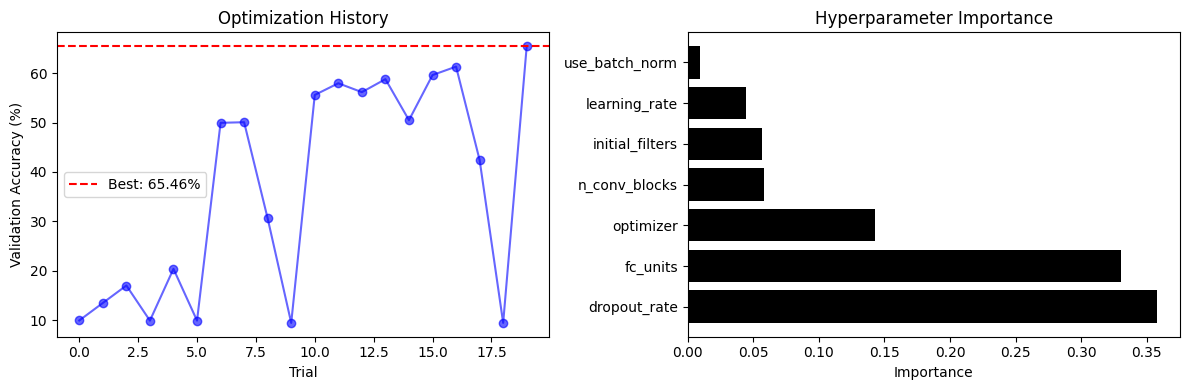

In [10]:
# Plot optimization history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Optimization history
axes[0].set_title('Optimization History')

# Trial values over time
trial_numbers = [t.number for t in study.trials if t.value is not None]
trial_values = [t.value for t in study.trials if t.value is not None]

axes[0].plot(trial_numbers, trial_values, 'bo-', alpha=0.6)
axes[0].axhline(y=study.best_value, color='r', linestyle='--', label=f'Best: {study.best_value:.2f}%')
axes[0].set_xlabel('Trial')
axes[0].set_ylabel('Validation Accuracy (%)')
axes[0].legend()

# Hyperparameter importance (if enough trials completed)
axes[1].set_title('Hyperparameter Importance')
completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

if len(completed_trials) >= 5:
    importance = optuna.importance.get_param_importances(study)
    params = list(importance.keys())
    values = list(importance.values())
    
    axes[1].set_xlabel('Importance')
    axes[1].barh(params, values, color='black')

else:
    axes[1].text(
        0.5, 0.5,
        'Not enough completed trials\nfor importance analysis', 
        ha='center', va='center', transform=axes[1].transAxes
    )

plt.tight_layout()
plt.show()

## 4. Train final model with best hyperparameters

### 4.1. Create optimized model

In [11]:
# Extract best hyperparameters
best_params = study.best_trial.params

print('Best hyperparameters:')
for key, value in best_params.items():
    print(f'  {key}: {value}')

# Create model with best hyperparameters
best_model = create_cnn(
    n_conv_blocks=best_params['n_conv_blocks'],
    initial_filters=best_params['initial_filters'],
    fc_units=best_params['fc_units'],
    dropout_rate=best_params['dropout_rate'],
    use_batch_norm=best_params['use_batch_norm']
).to(device)

# Create optimizer with best hyperparameters
if best_params['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])

elif best_params['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(
        best_model.parameters(), 
        lr=best_params['learning_rate'],
        momentum=best_params.get('sgd_momentum', 0.9)
    )

else:  # RMSprop
    best_optimizer = optim.RMSprop(best_model.parameters(), lr=best_params['learning_rate'])

criterion = nn.CrossEntropyLoss()

trainable_params = sum(p.numel() for p in best_model.parameters() if p.requires_grad)
print(f'\nModel architecture:')
print(best_model)
print(f'\nTotal trainable parameters: {trainable_params:,}')

Best hyperparameters:
  n_conv_blocks: 3
  initial_filters: 32
  fc_units: 512
  dropout_rate: 0.3348466136238071
  use_batch_norm: True
  learning_rate: 0.00015314276417033215
  optimizer: Adam

Model architecture:
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.3348466136238071, inplace=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(64, eps=1e-05, momentu

### 4.2. Train optimized model

In [12]:
%%time

history = train_model(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=best_optimizer,
    epochs=n_epochs_final,
    print_every=10
)

Epoch 1/100 - loss: 2.1315 - accuracy: 21.31% - val_loss: 2.5758 - val_accuracy: 10.56%
Epoch 10/100 - loss: 1.2246 - accuracy: 56.33% - val_loss: 1.4898 - val_accuracy: 50.30%
Epoch 20/100 - loss: 0.9456 - accuracy: 66.74% - val_loss: 0.9819 - val_accuracy: 65.76%
Epoch 30/100 - loss: 0.8086 - accuracy: 71.70% - val_loss: 0.8064 - val_accuracy: 71.88%
Epoch 40/100 - loss: 0.7145 - accuracy: 74.97% - val_loss: 0.7999 - val_accuracy: 72.33%
Epoch 50/100 - loss: 0.6344 - accuracy: 77.78% - val_loss: 0.7065 - val_accuracy: 75.34%
Epoch 60/100 - loss: 0.5779 - accuracy: 79.81% - val_loss: 0.6451 - val_accuracy: 77.65%
Epoch 70/100 - loss: 0.5246 - accuracy: 81.56% - val_loss: 0.6530 - val_accuracy: 77.67%
Epoch 80/100 - loss: 0.4806 - accuracy: 83.03% - val_loss: 0.5963 - val_accuracy: 79.15%
Epoch 90/100 - loss: 0.4418 - accuracy: 84.69% - val_loss: 0.6227 - val_accuracy: 79.07%
Epoch 100/100 - loss: 0.4134 - accuracy: 85.55% - val_loss: 0.5607 - val_accuracy: 81.14%

Training complete.
C

### 4.3. Learning curves

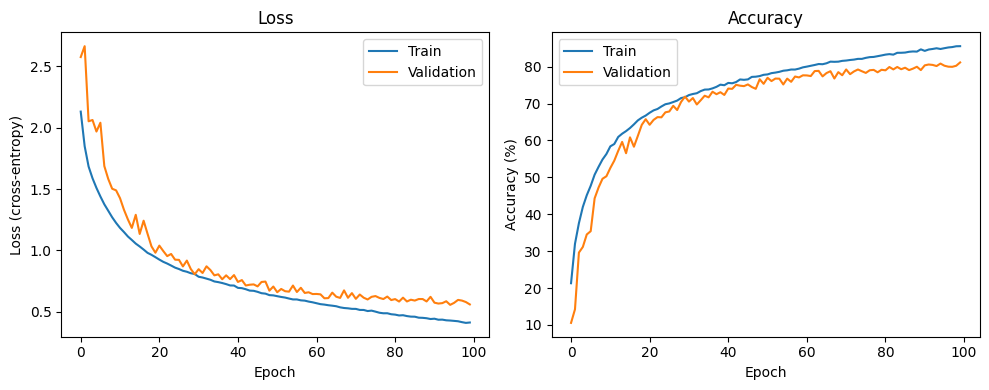

In [ ]:
fig, axes = plot_learning_curves(history)
plt.show()

## 5. Evaluate optimized model on test set

### 5.1. Calculate test accuracy

In [14]:
test_accuracy, predictions, true_labels = evaluate_model(best_model, test_loader)
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 80.88%


### 5.2. Per-class accuracy

In [15]:
# Calculate per-class accuracy
class_correct = {name: 0 for name in class_names}
class_total = {name: 0 for name in class_names}

for pred, true in zip(predictions, true_labels):

    class_name = class_names[true]
    class_total[class_name] += 1

    if pred == true:
        class_correct[class_name] += 1

print('Per-class accuracy:')
print('-' * 30)

for name in class_names:
    acc = 100 * class_correct[name] / class_total[name]
    print(f'{name:12s}: {acc:.2f}%')

Per-class accuracy:
------------------------------
airplane    : 77.60%
automobile  : 88.70%
bird        : 66.90%
cat         : 56.10%
deer        : 83.80%
dog         : 77.30%
frog        : 89.80%
horse       : 88.00%
ship        : 88.40%
truck       : 92.20%


### 5.3. Confusion matrix

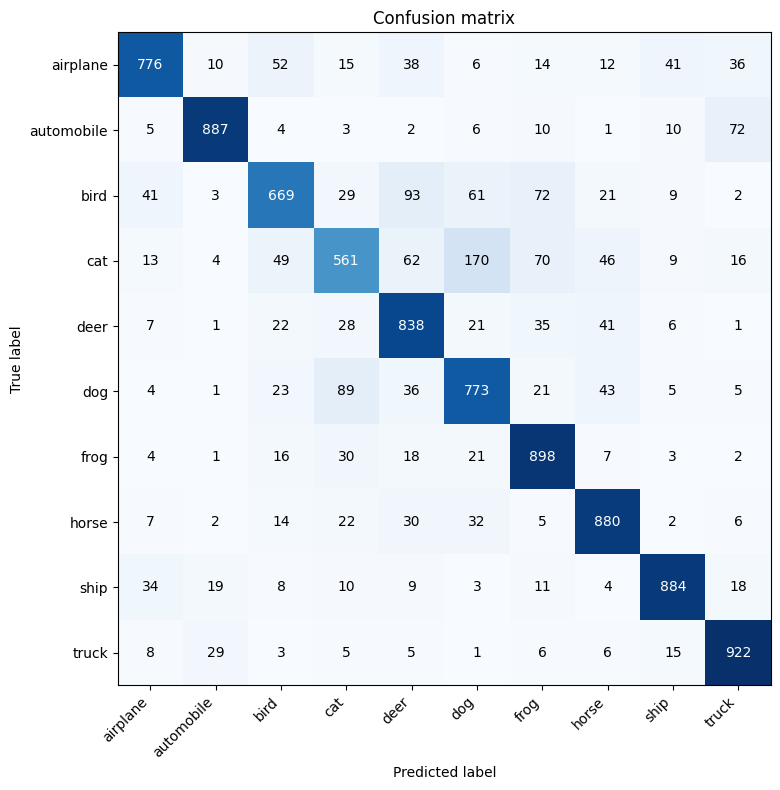

In [ ]:
fig, ax = plot_confusion_matrix(true_labels, predictions, class_names)
plt.show()

### 5.4. Predicted class probability distributions

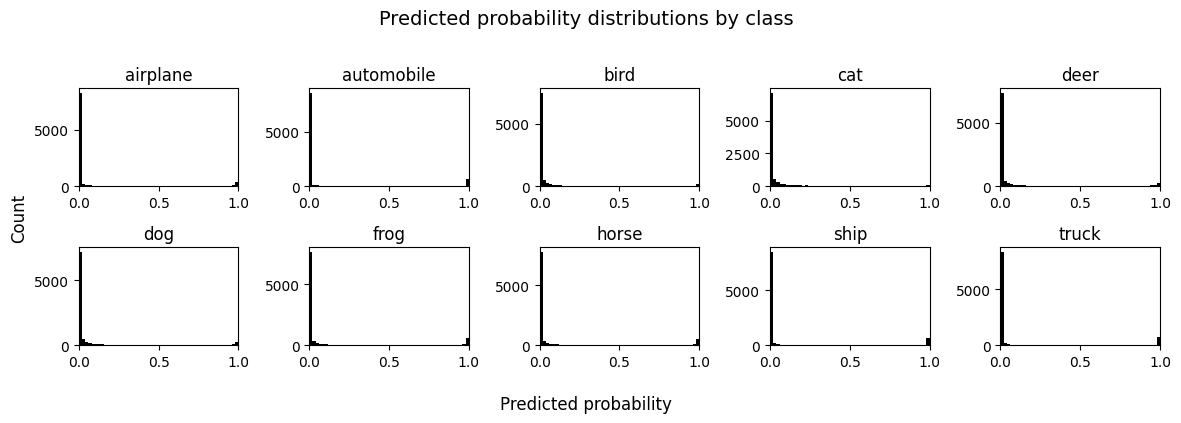

In [ ]:
# Get predicted probabilities for all test samples
best_model.eval()
all_probs = []

with torch.no_grad():
    for images, _ in test_loader:
        outputs = best_model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)

# Plot probability distributions
fig, axes = plot_class_probability_distributions(all_probs, class_names)
plt.show()

### 5.5. Evaluation curves

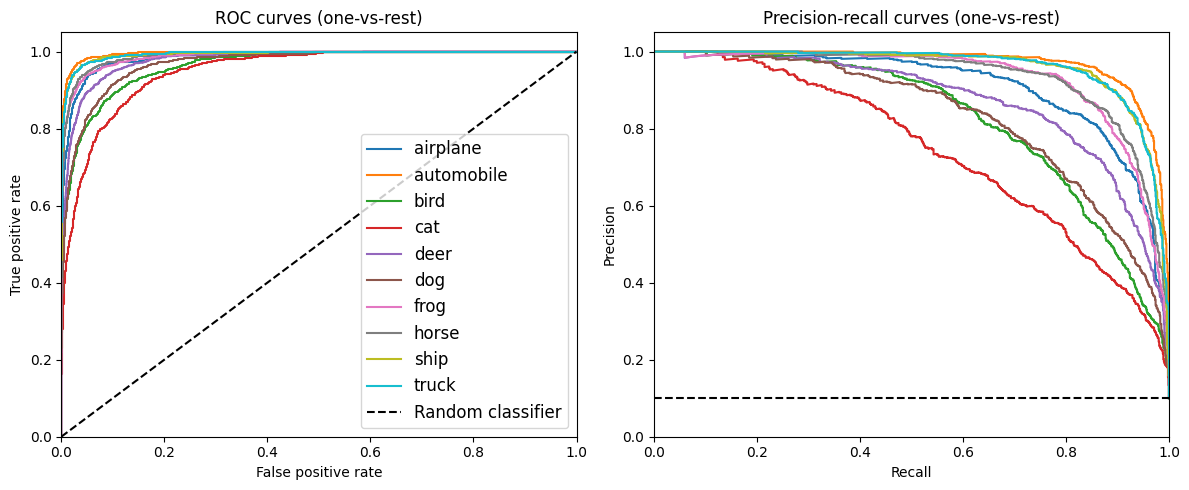

In [18]:
# Binarize true labels for one-vs-rest evaluation
y_test_bin = label_binarize(true_labels, classes=range(len(class_names)))

# Create figure with ROC and PR curves side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ROC curves for each class
ax1.set_title('ROC curves (one-vs-rest)')

for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, label=class_name)

ax1.plot([0, 1], [0, 1], 'k--', label='Random classifier')
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.legend(loc='lower right', fontsize=12)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1.05])

# Plot Precision-Recall curves for each class
ax2.set_title('Precision-recall curves (one-vs-rest)')

for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], all_probs[:, i])
    ap = average_precision_score(y_test_bin[:, i], all_probs[:, i])
    ax2.plot(recall, precision)

# Random classifier baseline (horizontal line at class prevalence = 1/num_classes)
baseline = 1 / len(class_names)
ax2.axhline(y=baseline, color='k', linestyle='--')

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

## 6. Save optimized model and hyperparameters

In [19]:
# Create models directory if it doesn't exist
models_dir = Path('../models')
models_dir.mkdir(parents=True, exist_ok=True)

# Save model state dict
model_path = models_dir / 'optimized_cnn.pth'

torch.save({
    'model_state_dict': best_model.state_dict(),
    'optimizer_state_dict': best_optimizer.state_dict(),
    'best_params': best_params,
    'test_accuracy': test_accuracy,
    'history': history
}, model_path)

print(f'Model saved to: {model_path}')
print(f'Test accuracy: {test_accuracy:.2f}%')

Model saved to: ../models/optimized_cnn.pth
Test accuracy: 80.88%
